# The idea

In my previous blog post, we got to know the idea of "indentation-based complexity". We took a static view on the Linux kernel to spot the most complex areas.

This time, we wanna track the evolution of the indentation-based complexity of a software system over time. We are especially interested in it's correlation between the lines of code. Because if we have a more or less stable development of the lines of codes of our system, but an increasing number of indentation per source code file, we surely got a complexity problem.

Again, this analysis is higly inspired by [Adam Tornhill's book "Software Design X-Ray"](https://pragprog.com/book/atevol/software-design-x-rays)
, which I currently always recommend if you want to get a deep dive into software data analysis.

# The data
For the calculation of the evolution of our software system, we can use data from the version control system. In our case, we can get all changes to Java source code files with Git. We just need so say the right magic words, which is

```git log -p -- *.java```

This gives us data like the following:

```
commit e5254156eca3a8461fa758f17dc5fae27e738ab5
Author: Antoine Rey <antoine.rey@gmail.com>
Date:   Fri Aug 19 18:54:56 2016 +0200

    Convert Controler's integration test to unit test

diff --git a/src/test/java/org/springframework/samples/petclinic 
/web/CrashControllerTests.java b/src/test/java/org/springframework/samples/petclinic/web/CrashControllerTests.java
index ee83b8a..a83255b 100644
--- a/src/test/java/org/springframework/samples/petclinic/web/CrashControllerTests.java
+++ b/src/test/java/org/springframework/samples/petclinic/web/CrashControllerTests.java
@@ -1,8 +1,5 @@
 package org.springframework.samples.petclinic.web;
 
-import static org.springframework.test.web.servlet.request.MockMvcRequestBuilders.get;
-import static org.springframework.test.web.servlet.result.MockMvcResultMatchers.*;
-
 import org.junit.Before;
 import org.junit.Test;
 import org.junit.runner.RunWith;
```

We have the
* commit sha  
```    commit e5254156eca3a8461fa758f17dc5fae27e738ab5```
* author's name  
```    Author: Antoine Rey <antoine.rey@gmail.com>```
* date of the commit  
```    Date:   Fri Aug 19 18:54:56 2016 +0200```
* commit message  
```    Convert Controler's integration test to unit test```
* names of the files that changes (after and before)  
```   diff --git a/src/test/java/org/springframework/samples/petclinic 
/web/CrashControllerTests.java b/src/test/java/org/springframework/samples/petclinic/web/CrashControllerTests.java```
* the extended index header  
```   index ee83b8a..a83255b 100644```  
```   --- a/src/test/java/org/springframework/samples/petclinic/web/CrashControllerTests.java
+++ b/src/test/java/org/springframework/samples/petclinic/web/CrashControllerTests.java``` 
* and the full file diff where we can see additions or modifications (`+`) and deletions (`-`)   
```
    package org.springframework.samples.petclinic.web;
 
    -import static org.springframework.test.web.servlet.request.MockMvcRequestBuilders.get;
    -import static org.springframework.test.web.servlet.result.MockMvcResultMatchers.*;     
    -
     import org.junit.Before;
```
We "just" have to get this data into our favorite data analysis framework, which is, of course, Pandas :-). We can actually do that! Let's see how!

# Advanced data wangling
Reading in such a semi-structured data is a little challenge. But we can do it with some tricks. First, we read in the whole Git diff history by standard means, using `read_csv` and the separator `\n` to get one row per line. We make sure to give the columns a nice name as well.

In [2]:
import pandas as pd

diff_raw = pd.read_csv(
    "../../buschmais-spring-petclinic_fork/git_diff.log",
    sep="\n",
    names=["raw"])
diff_raw.head(5)

,raw
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5
1,Author: Antoine Rey <antoine.rey@gmail.com>
2,Date: Fri Aug 19 18:54:56 2016 +0200
3,Convert Controler's integration test to un...
4,diff --git a/src/test/java/org/springframework...


In [75]:
diff_raw[diff_raw.raw.str.startswith("commit")]t

,raw
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5
288,commit 1a6572d1ac0c7659d9243405074f3f19f9a93328
409,commit 078bdc6cfbada99413041d859fdeb3d63685c40b
446,commit 4c722465d8091cfa29b54674138c24c199259172
525,commit ca755be44a2844e10876b8e38e68b9adf736b486
641,commit ad3d322fc69061d5009460689edfda09af0b53ce
792,commit 845d31e8ed07c60ae2bdf79b241423a88c6b471d
1368,commit e00dfb3fe05cef910495b38d5a24221188e2e1a6
1436,commit 92de6557e10b610f3ea6579a6be67c53c4f766bc
1510,commit 4aa89ae4e2b75e37aa8869b48ab1908e61af74e0


The output is the commit data that I've describe above where each in line the text file represents one row in the DataFrame (without blank lines).

## Cleansing
We skip all the data we don't need for sure. Especially the "extended index header" with the two lines that being with `+++` and `---` are candidates to mix with the real diff data that begins also with a `+` or a `-`. Furtunately, we can identify these rows easily: These are the rows that begin with the row that starts with `index`. Using the `shift` operation starting at the row with `index`, we can get rid of all those lines.

In [6]:
index_row = diff_raw.raw.str.startswith("index ")
ignored_diff_rows = (index_row.shift(1) | index_row.shift(2))
diff_raw = diff_raw[~(index_row | ignored_diff_rows)]
diff_raw.head(10)

,raw
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5
1,Author: Antoine Rey <antoine.rey@gmail.com>
2,Date: Fri Aug 19 18:54:56 2016 +0200
3,Convert Controler's integration test to un...
4,diff --git a/src/test/java/org/springframework...
8,"@@ -1,8 +1,5 @@"
9,package org.springframework.samples.petclinic...
10,-import static org.springframework.test.web.se...
11,-import static org.springframework.test.web.se...
12,-


## Extracting metadata

Next, we extract some metadata of a commit. We can identify the different entries by using a regular expression that looks up a specific key word for each line. We extract each individual information into a new Series/column because we need it for each change line during the software's history. 

In [7]:
diff_raw['commit'] = diff_raw.raw.str.split("^commit ").str[1]
diff_raw['timestamp'] = pd.to_datetime(diff_raw.raw.str.split("^Date: ").str[1])
diff_raw['path'] = diff_raw.raw.str.extract("^diff --git.* b/(.*)", expand=True)[0]
diff_raw.head()

,raw,commit,timestamp,path
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN
1,Author: Antoine Rey <antoine.rey@gmail.com>,NaN,NaT,NaN
2,Date: Fri Aug 19 18:54:56 2016 +0200,NaN,2016-08-19 16:54:56,NaN
3,Convert Controler's integration test to un...,NaN,NaT,NaN
4,diff --git a/src/test/java/org/springframework...,NaN,NaT,src/test/java/org/springframework/samples/petc...


To assign each commit's metadata to the remaining rows, we forward fill those rows with the metadata by using the `fillna` method. 

In [9]:
diff_raw = diff_raw.fillna(method='ffill')
diff_raw.head(8)

,raw,commit,timestamp,path
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN
1,Author: Antoine Rey <antoine.rey@gmail.com>,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN
2,Date: Fri Aug 19 18:54:56 2016 +0200,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN
3,Convert Controler's integration test to un...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN
4,diff --git a/src/test/java/org/springframework...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...
8,"@@ -1,8 +1,5 @@",e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...
9,package org.springframework.samples.petclinic...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...
10,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...


## Identifying source code lines
We can now focus on the changed source code lines. We can identify 

In [26]:
%%timeit
diff_raw.raw.str.extract("^\+( *).*$", expand=True)[0].str.len()

60.1 ms ± 8.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
diff_raw["i"] = diff_raw.raw.str[1:].str.len() - diff_raw.raw.str[1:].str.lstrip().str.len()
diff_raw

,raw,commit,timestamp,path,i
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN,0
1,Author: Antoine Rey <antoine.rey@gmail.com>,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN,0
2,Date: Fri Aug 19 18:54:56 2016 +0200,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN,0
3,Convert Controler's integration test to un...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN,3
4,diff --git a/src/test/java/org/springframework...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,0
8,"@@ -1,8 +1,5 @@",e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,0
9,package org.springframework.samples.petclinic...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,0
10,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,0
11,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,0
12,-,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,0


In [ ]:
%%timeit
diff_raw.raw.str[0] + diff_raw.raw.str.[1:].str.lstrip().str.len()

In [7]:
diff_raw['added'] = diff_raw.line.str.extract("^\+( *).*$", expand=True)[0].str.len()
diff_raw['deleted'] = diff_raw.line.str.extract("^-( *).*$", expand=True)[0].str.len()
diff_raw.head()

,raw,commit,timestamp,path,line,added,deleted
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN,commit e5254156eca3a8461fa758f17dc5fae27e738ab5,NaN,NaN
1,Author: Antoine Rey <antoine.rey@gmail.com>,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN,Author: Antoine Rey <antoine.rey@gmail.com>,NaN,NaN
2,Date: Fri Aug 19 18:54:56 2016 +0200,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN,Date: Fri Aug 19 18:54:56 2016 +0200,NaN,NaN
3,Convert Controler's integration test to un...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN,Convert Controler's integration test to un...,NaN,NaN
4,diff --git a/src/test/java/org/springframework...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,diff --git a/src/test/java/org/springframework...,NaN,NaN


For our later indentation-based complexity calculation, we have to make sure that each line

In [6]:
diff_raw['line'] = diff_raw.raw.str.replace("\t", "    ")
diff_raw.head()

,raw,commit,timestamp,path,line
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN,commit e5254156eca3a8461fa758f17dc5fae27e738ab5
1,Author: Antoine Rey <antoine.rey@gmail.com>,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN,Author: Antoine Rey <antoine.rey@gmail.com>
2,Date: Fri Aug 19 18:54:56 2016 +0200,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN,Date: Fri Aug 19 18:54:56 2016 +0200
3,Convert Controler's integration test to un...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN,Convert Controler's integration test to un...
4,diff --git a/src/test/java/org/springframework...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,diff --git a/src/test/java/org/springframework...


In [8]:
diff = \
    diff_raw[
        (~diff_raw['added'].isnull()) | 
             (~diff_raw['deleted'].isnull())].copy()
diff.head()

,raw,commit,timestamp,path,line,added,deleted
10,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0
11,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0
12,-,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-,NaN,0.0
19,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN
20,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN


In [9]:
diff['is_comment'] = diff.line.str[1:].str.match(r' *(//|/*\*).*')
diff['is_empty'] = diff.line.str[1:].str.replace(" ","").str.len() == 0
diff['is_source'] = ~(diff['is_empty'] | diff['is_comment'])
diff.head()

,raw,commit,timestamp,path,line,added,deleted,is_comment,is_empty,is_source
10,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0,False,False,True
11,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0,False,False,True
12,-,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-,NaN,0.0,False,True,False
19,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN,False,False,True
20,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN,False,False,True


In [10]:
diff.raw.str[0].value_counts()

+    15750
-    11792
Name: raw, dtype: int64

In [11]:
diff['lines_added'] = (~diff.added.isnull()).astype('int')
diff['lines_deleted'] = (~diff.deleted.isnull()).astype('int')
diff.head()

,raw,commit,timestamp,path,line,added,deleted,is_comment,is_empty,is_source,lines_added,lines_deleted
10,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0,False,False,True,0,1
11,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0,False,False,True,0,1
12,-,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-,NaN,0.0,False,True,False,0,1
19,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN,False,False,True,1,0
20,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN,False,False,True,1,0


In [12]:
diff = diff.fillna(0)
#diff.to_excel("temp.xlsx")
diff.head()

,raw,commit,timestamp,path,line,added,deleted,is_comment,is_empty,is_source,lines_added,lines_deleted
10,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,0.0,0.0,False,False,True,0,1
11,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,0.0,0.0,False,False,True,0,1
12,-,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-,0.0,0.0,False,True,False,0,1
19,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,0.0,False,False,True,1,0
20,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,0.0,False,False,True,1,0


In [13]:
commits_per_day = diff.set_index('timestamp').resample("D").sum()
commits_per_day.head()

,added,deleted,is_comment,is_empty,is_source,lines_added,lines_deleted
timestamp,,,,,,,
2009-05-05,644.0,12.0,0.0,87.0,194.0,277,4
2009-05-06,988.0,684.0,2.0,184.0,433.0,356,263
2009-05-07,612.0,48.0,1.0,60.0,138.0,189,10
2009-05-08,0.0,0.0,0.0,0.0,0.0,0,0
2009-05-09,0.0,0.0,0.0,0.0,0.0,0,0


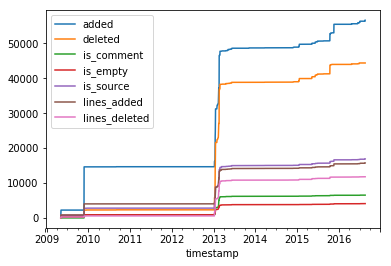

In [14]:
%matplotlib inline
commits_per_day.cumsum().plot()

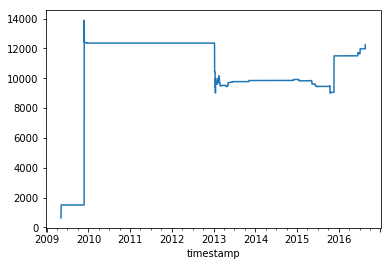

In [15]:
(commits_per_day.added - commits_per_day.deleted).cumsum().plot()

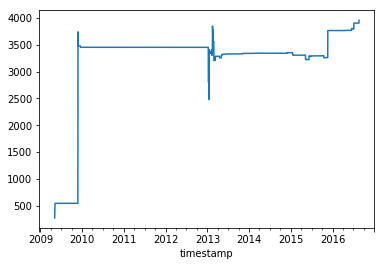

In [ ]:
(commits_per_day.lines_added - commits_per_day.lines_deleted).cumsum().plot()

In [ ]:
diff_sum = diff.sum()
diff_sum.lines_added - diff_sum.lines_deleted                                                    

In [ ]:
3913